In [502]:
import LibsControl
import numpy
import matplotlib.pyplot as plt


#sampling rate
dt = 1.0/4000.0


#input parameters
#create example 1st order motor

u_max       = 12.0     #input max magnitude (e.g. volts)
rpm_max     = 1000     #rpm on u_max (free run RPM)
tau         = 0.03     #motor time constant, seconds



rad_max = (rpm_max/60.0)*(2.0*numpy.pi) #rpm to rad/s

k = (rad_max/u_max)

#continuous time dynamics
mat_a = numpy.zeros((1, 1))
mat_b = numpy.zeros((1, 1))
mat_c = numpy.eye(1)
 
mat_a[0][0] = -1.0/tau    
mat_b[0][0] = k*(1.0/tau)



#create dynamical system
ds = LibsControl.DynamicalSystem(mat_a, mat_b, mat_c, dt)


print("continuous reference model")
print("k   = ", k)
print("tau = ", tau)
print("a   = ", mat_a)
print("b   = ", mat_b)
print()


continuous reference model
k   =  8.726646259971648
tau =  0.03
a   =  [[-33.33333333]]
b   =  [[290.88820867]]



k_mean =  8.72783
x_var  =  0.101
tau =  0.02829


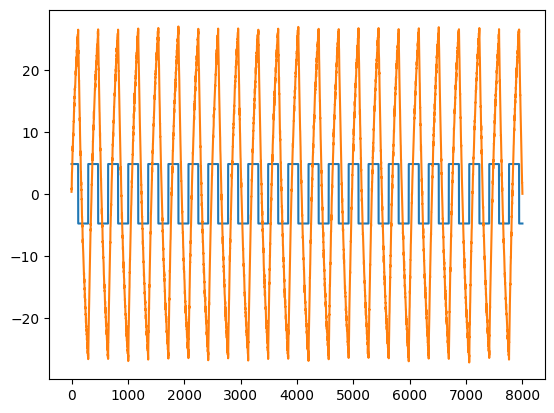

In [503]:
#motor identification


n_steps = 1000

#example noise variance
noise_var = 0.1

# estimate motor constant k, on different speeds

u_values = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
u_values = u_max*numpy.array(u_values)

k_values   = []
x_variance = []

for u_in in u_values:

    #wait for steady state
    for i in range(n_steps):
        x, _ = ds.forward_state( u_in*numpy.ones((1, 1)) )

    #estimate motor free run speed
    x_mean = 0.0
    for i in range(n_steps):
        x, _ = ds.forward_state( u_in*numpy.ones((1, 1)) )
        x = x[0][0] + (noise_var**0.5)*numpy.random.randn()
        x_mean+= x
    x_mean = x_mean/n_steps

    #estimate noise variance
    x_var = 0.0
    for i in range(n_steps):
        x, _ = ds.forward_state( u_in*numpy.ones((1, 1)) )
        x = x[0][0] + (noise_var**0.5)*numpy.random.randn()
        x_var+= (x - x_mean)**2
    x_var = x_var/n_steps

    k_est = x_mean/u_in

    k_values.append(k_est)
    x_variance.append(x_var)





k_values = numpy.array(k_values)
k_mean = k_values.mean()

x_var = numpy.array(x_var)
x_var = x_var.mean()

print("k_mean = ", round(k_mean, 5))
print("x_var  = ", round(x_var, 5))



#estimate motor time constant

#wait for motor stop
for i in range(n_steps):
    x, _ = ds.forward_state(0*numpy.ones((1, 1)) )



n_steps = int(2.0/dt)

u_in = u_max*0.4

u_result = []
x_result = []
periods = 0
for i in range(n_steps):
    x, _ = ds.forward_state(u_in*numpy.ones((1, 1)) )
    x = x[0][0] + (noise_var**0.5)*numpy.random.randn()

    # brings motor to oscillations
    if u_in > 0.0:
        if x > 0.632*k*u_in:
            u_in = -u_in
            periods+= 1
    else:
        if x < 0.632*k*u_in:
            u_in = -u_in
            periods+= 1

    u_result.append(u_in)
    x_result.append(x)

t_period = (2*n_steps/periods)*dt/numpy.pi


print("tau = ", round(t_period, 5))

plt.plot(u_result)
plt.plot(x_result)

